In [62]:
import random
import torch
import copy
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import random_split
import torch.optim as optim
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
import torch.nn.functional as F

In [3]:
print(torch.__version__)

2.0.1+cu118


In [4]:
data_path = "/content/datasets"
num_batch = 64

In [5]:
#define the mean and standrad deviation values for normalization
#use to transform datasets in
# number system range 0-1 so that torch library can understand
T = transforms.Compose([
       transforms.ToTensor()
    ])

In [6]:
#The MNIST dataset consists of handwritten digit images
train_dataset = datasets.MNIST(root=data_path,
                               train=True,
                               download=True,
                               transform=T)

val_dataset = datasets.MNIST(root=data_path,
                              download=False,
                              transform=T)
#train data loder
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=num_batch)
val_dl = torch.utils.data.DataLoader(val_dataset, batch_size=num_batch)


100%|██████████| 9912422/9912422 [00:00<00:00, 456169136.22it/s]

Extracting /content/datasets/MNIST/raw/train-images-idx3-ubyte.gz to /content/datasets/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 69538285.78it/s]


Extracting /content/datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /content/datasets/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 182626723.62it/s]

Extracting /content/datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/datasets/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 12845939.83it/s]


Extracting /content/datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/datasets/MNIST/raw



**Look into input data**

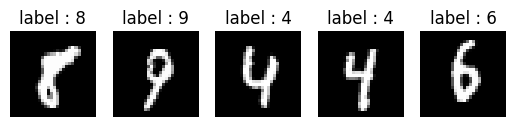

In [7]:
import random
import matplotlib.pyplot as plt

# Display a few sample images from the MNIST dataset- define number
num_samples = 5

# Get random indices for the images in the dataset
random_indices = random.sample(range(len(train_dataset)), num_samples)

#iterate labels with images and display it
for i , idx in enumerate(random_indices):
  image, label = train_dataset[idx]
  image = image.squeeze()  # Remove the single-dimensional channel dimension if present

  #plot images
  plt.subplot(1, num_samples, i + 1)
  plt.imshow(image, cmap='gray')
  plt.title(f"label : {label}")
  plt.axis('off')

# Show the plot
plt.show()

In [7]:
len(train_dataset)

60000

In [8]:
print('total images :', train_dataset.data.shape[0])
print('size: ', train_dataset.data.shape[1:])

total images : 60000
size:  torch.Size([28, 28])


**Prepare input data**

In [9]:
def create_lenet():
  model = nn.Sequential(
      nn.Conv2d(1, 6, 5, padding = 2),
      nn.ReLU(),
      nn.AvgPool2d(2, stride=2),

      nn.Conv2d(6, 16, 5, padding=0),
      nn.ReLU(),
      nn.AvgPool2d(2, stride=2),

      nn.Flatten(),
      nn.Linear(400, 120),
      nn.ReLU(),
      nn.Linear(120, 84),
      nn.ReLU(),
      nn.Linear(84, 10)
  )
  return model

In [10]:
def validate(model, data):
  total = 0
  correct = 0
  for i, (images, labels) in enumerate(data):
    images = images.cuda()
    x = model(images)
    value, pred = torch.max(x, 1)

    pred = pred.data.cpu()
    total += x.size(0)
    correct += torch.sum(pred == labels)
  return correct*100./total

In [11]:
def train(num_epochs=3, lr=1e-3, device='cpu'):
    accuracies = []
    cnn = create_lenet().to(device)
    cec = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=lr)
    max_accuracy = 0

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_dl):
            print("Type of labels:", type(labels))
            print("Value of labels:", labels)
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            pred = cnn(images)
            loss = cec(pred, labels)
            loss.backward()
            optimizer.step()

        accuracy = float(validate(cnn, val_dl))
        accuracies.append(accuracy)
        if accuracy > max_accuracy:
            best_model = copy.deepcopy(cnn)
            max_accuracy = accuracy
            print("Saving best model with accuracy:", accuracy)
        print("Epoch:", epoch + 1, "Accuracy:", accuracy, "%")

    plt.plot(accuracies)
    return best_model


In [12]:
import torch
if torch.cuda.is_available():
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")

In [13]:
device

device(type='cuda', index=0)

Streaming output truncated to the last 5000 lines.
Type of labels: <class 'torch.Tensor'>
Value of labels: tensor([8, 9, 4, 7, 3, 1, 7, 1, 6, 9, 0, 0, 2, 7, 3, 3, 7, 4, 0, 8, 2, 6, 1, 3,
        5, 8, 2, 0, 8, 6, 4, 2, 2, 1, 1, 0, 3, 1, 9, 0, 3, 6, 8, 2, 0, 3, 8, 8,
        4, 9, 7, 0, 4, 7, 7, 2, 2, 3, 0, 4, 6, 5, 9, 5])
Type of labels: <class 'torch.Tensor'>
Value of labels: tensor([9, 2, 4, 8, 1, 5, 8, 4, 9, 6, 8, 6, 1, 6, 1, 7, 5, 9, 8, 1, 1, 8, 0, 2,
        2, 1, 5, 2, 4, 6, 8, 5, 2, 3, 0, 4, 4, 7, 3, 9, 4, 4, 7, 0, 5, 0, 9, 5,
        6, 9, 1, 0, 0, 1, 5, 2, 3, 3, 7, 4, 0, 5, 1, 6])
Type of labels: <class 'torch.Tensor'>
Value of labels: tensor([8, 7, 5, 8, 1, 9, 2, 0, 0, 1, 3, 2, 7, 3, 2, 5, 0, 6, 1, 7, 2, 8, 7, 9,
        7, 0, 0, 1, 1, 2, 7, 3, 4, 4, 4, 5, 0, 6, 6, 7, 7, 8, 4, 9, 4, 0, 4, 7,
        0, 0, 7, 7, 6, 8, 0, 3, 1, 0, 9, 0, 8, 5, 3, 5])
Type of labels: <class 'torch.Tensor'>
Value of labels: tensor([3, 3, 5, 8, 0, 8, 0, 1, 9, 8, 0, 4, 5, 9, 9, 6, 2, 1, 8, 8, 1, 0, 

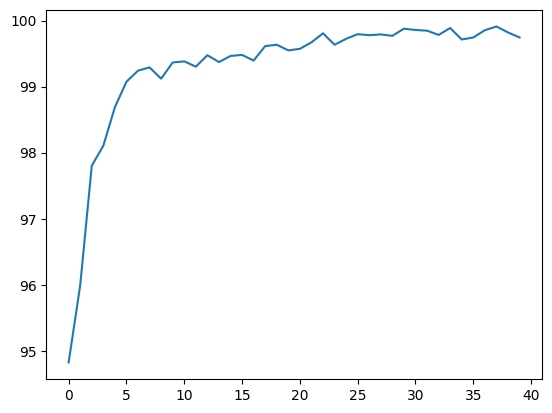

In [51]:
lenet = train(40, device=device)

In [52]:
def predict_dl(model, data):
  y_pred = []
  y_true = []
  for i, (images, labels) in enumerate(data):
    images = images.cuda()
    x = model(images)
    value, pred = torch.max(x, 1)
    pred = pred.data.cpu()
    y_pred.extend(list(pred.numpy()))
    y_true.extend(list(labels.numpy()))
  return np.array(y_pred), np.array(y_true)

In [53]:
y_pred, y_true = predict_dl(lenet, val_dl)

In [54]:
pd.DataFrame(confusion_matrix(y_true, y_pred, labels= np.arange(0, 10)))

,0,1,2,3,4,5,6,7,8,9
0,5923,0,0,0,0,0,0,0,0,0
1,0,6741,0,0,0,0,0,1,0,0
2,0,0,5956,0,0,0,0,2,0,0
3,0,0,1,6120,0,6,0,1,0,3
4,0,0,0,0,5838,0,0,1,0,3
5,0,0,1,0,0,5420,0,0,0,0
6,0,1,0,0,0,22,5894,0,1,0
7,0,1,0,0,0,0,0,6263,0,1
8,0,0,1,0,0,1,0,0,5849,0
9,0,0,0,0,5,0,0,2,0,5942


#define inference function

In [55]:
def inference(path, model, device):
    r = requests.get(path)
    with BytesIO(r.content) as f:
        img = Image.open(f).convert(mode="L")
        img = img.resize((28, 28))
        x = (255 - np.expand_dims(np.array(img), -1)) / 255.0
    with torch.no_grad():
        pred = model(torch.unsqueeze(T(x), axis=0).float().to(device))
        return F.softmax(pred, dim=-1).cpu().numpy()

In [59]:
import requests
from PIL import Image
import numpy as np

url = "https://previews.123rf.com/images/aroas/aroas1704/aroas170400068/79321959-handwritten-sketch-black-number-8-on-white-background.jpg"
response = requests.get(url)

with Image.open(BytesIO(response.content)) as img:
    img = img.convert("L")  # Convert to grayscale
    img = img.resize((28, 28))  # Resize to 28x28 pixels
    x = (255 - np.expand_dims(np.array(img), -1)) / 255.0


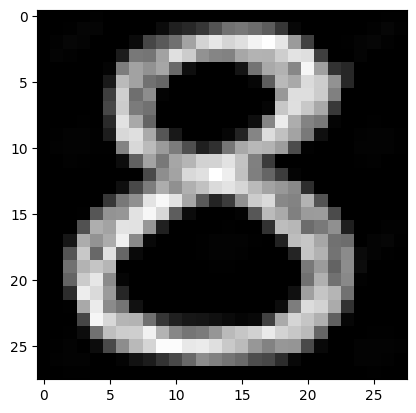

In [60]:
plt.imshow(x.squeeze(-1), cmap = "gray")

In [61]:
pred = inference(url, lenet, device=device)
pred_idx = np.argmax(pred)
print(f"predicted: {pred_idx}, prob: {pred[0][pred_idx]*100} %")

predicted: 3, prob: 86.21097207069397 %
